In [19]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit import IBMQ
from qiskit.tools.monitor import job_monitor

IBMQ.save_account('97d2733b7c11b188b0581ae8a2beda54ce1c210ae0274df456ec1ddbe7df9fddf6d104015c59d4f7ce651304bf82fbd8e7178ea759d5f6f8058950d9e7ebf2ad',overwrite=True)

IBMQ.load_account()


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [29]:
def simul(qc):
    backend = Aer.get_backend('qasm_simulator')
    result = execute(qc,backend,shots=3000).result().get_counts()
    return result
    
def run(circuit, backend, **kwargs):
    if type(backend) is str:
        backend = Aer.get_backend(backend)
    return execute(circuit, backend, **kwargs)

def printFound(results,collisions):
    for key in results:
        if(result_counts[key]>collisions):
          print(key, '->', result_counts[key])

In [20]:
def completeGraphWalk(N,qreg,qcoin):
    qc = QuantumCircuit(qreg,qcoin,name='CompleteGraph')
    qc.swap(qreg[0:N],qcoin)
    return qc

def hadamardCoin(N,qc,qcoin):
    qc.h(qcoin)
    return qc

def grover3Coin(N,qc,qcoin):
    qc.h(qcoin)
    qc.x(qcoin)
    qc.h(qcoin[2])
    qc.toffoli(qcoin[0],qcoin[1],qcoin[2])
    qc.h(qcoin[2])
    qc.x(qcoin)
    qc.h(qcoin)
    qc.barrier()
    return qc

In [21]:
def markedList(markedList,N):
    oracleList = np.ones(2**N)
    for element in markedList:
        oracleList[element] = -1
    return oracleList.tolist()

def diffusion(N):
    qreg = QuantumRegister(N)
    qcoin = QuantumRegister(N)
    difCirc = QuantumCircuit(qreg,qcoin,name='Diffusion')
    difCirc.h(qcoin)
    
    aux = markedList([0],N)
    qcAux = oracle(aux,N,True)
    difCirc.append(qcAux,range(2*N))
    
    difCirc.h(qcoin)
    return difCirc


In [22]:
def oracle(markedList,N,dif):
    qreg = QuantumRegister(N)
    qcoin = QuantumRegister(N)
    qc = QuantumCircuit(qreg,qcoin,name='Oracle')
    if(dif==True):
        qc.diagonal(markedList,qcoin)
    else:
        qc.diagonal(markedList,qreg)

    return qc

def runWalk(qc,qreg,qcoin,creg,markedVertex,backend,N,times):
    qc = QuantumCircuit(qreg,qcoin,creg)
    markedVertex=markedList(markedVertex,N)
    qcOracle = oracle(markedVertex,N,False)
    qcDif = diffusion(N)
    qcQWalk = completeGraphWalk(N,qreg,qcoin)
    qc.h(qreg)
    for i in range(times):
        qc.append(qcOracle,range(2*N))
        qc.barrier()
        qc.append(qcDif,range(2*N))
        qc.barrier()
        qc.append(qcQWalk,range(2*N))
        qc.barrier()

        
    qc = transpile(qc,backend=backend,basis_gates=['cx','u3','swap'],optimization_level=3)
    qc.measure(range(N),range(N))
        
    return qc

3


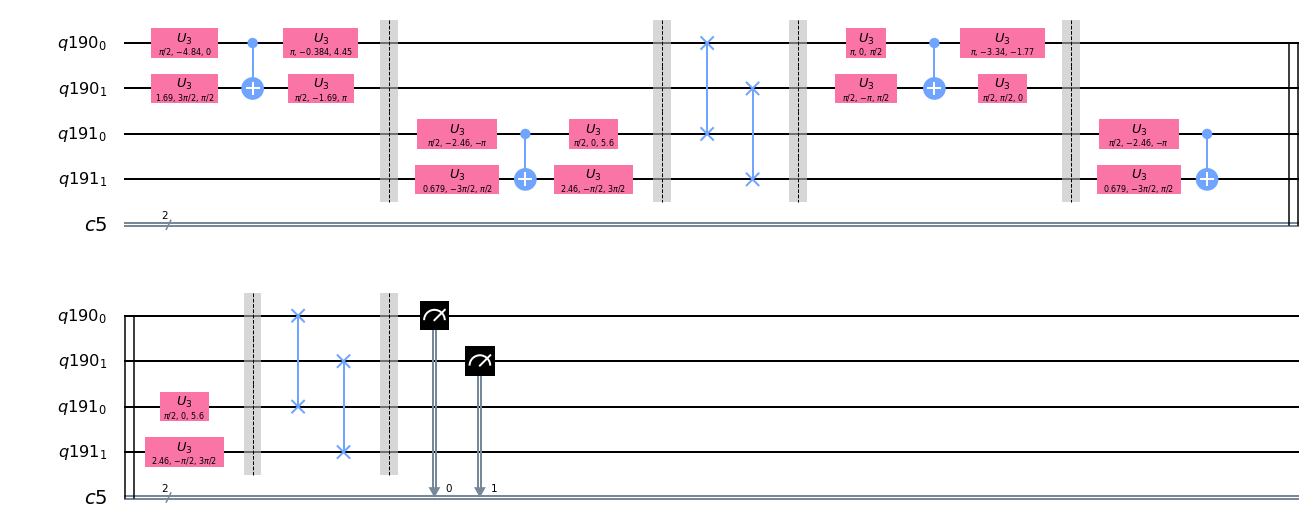

In [35]:
N=2

qreg = QuantumRegister(N)
qcoin = QuantumRegister(N)
creg = ClassicalRegister(N)

qc = QuantumCircuit(qreg,qcoin,creg)
#qc = diffusion(N)
times = int(np.sqrt(N))
limit = 2**N -1
print(limit)
qc = runWalk(qcm,leastBusybackend,qreg,qcoin,creg,[0],N,2)


    
qc.draw(output='mpl')

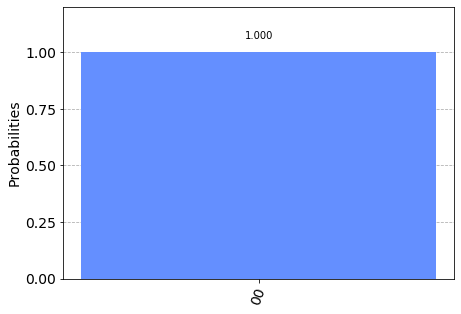

In [36]:
plot_histogram(simul(qc))

In [37]:
provider = IBMQ.get_provider(hub='ibm-q-minho', group='academicprojects', project='quantalab')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-minho', group='academicprojects', project='quantalab')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q-minho', group='academicprojects', project='quantalab')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q-minho', group='academicprojects', project='quantalab')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q-minho', group='academicprojects', project='quantalab')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q-minho', group='academicprojects', project='quantalab')>,
 <IBMQBackend('ibmq_valencia') from IBMQ(hub='ibm-q-minho', group='academicprojects', project='quantalab')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q-minho', group='academicprojects', project='quantalab')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q-minho', group='academicprojects', project='quantalab')>,
 <IBMQBackend('ibmq_johannesburg') from IBMQ(hub='ibm-q-minho', group='academicprojects', project='quantalab')>,
 <IBMQBackend('

In [38]:
from qiskit.providers.ibmq import least_busy
minQubits = 10

large_enough_devices = provider.backends(filters=lambda x: x.configuration().n_qubits > minQubits  and not x.configuration().simulator)

leastBusybackend = least_busy(large_enough_devices)
altBackend = provider.get_backend('ibmq_paris')
altBackend2 = provider.get_backend('ibmq_cambridge')

print("The best backend is " + leastBusybackend.name())
print("The alt backend is " + altBackend.name())
print("The alt2 backend is " + altBackend2.name())

The best backend is ibmq_johannesburg
The alt backend is ibmq_paris
The alt2 backend is ibmq_cambridge


In [39]:
result = run(qc,leastBusybackend)

In [40]:
altBackend.jobs(limit=50, skip=0, status=None, db_filter=None)

[IBMQJob(_api=<qiskit.providers.ibmq.api.clients.account.AccountClient object at 0x0000026899C199A0>, _api_status='COMPLETED', _backend=<IBMQBackend('ibmq_paris') from IBMQ(hub='ibm-q-minho', group='academicprojects', project='quantalab')>, _backend_info={'id': '5e6a6005ef0935c3e8b81fbb', 'name': 'ibmq_paris'}, _cancelled=False, _creation_date=datetime.datetime(2020, 6, 27, 13, 55, 47, 795000, tzinfo=tzutc()), _error=None, _job_error_msg=None, _job_id='5ef74fe3fb7fab0014a7fa23', _kind=<ApiJobKind.QOBJECT_STORAGE: 'q-object-external-storage'>, _name=None, _qobj=None, _queue_info=None, _result=None, _run_mode='fairshare', _status=<JobStatus.DONE: 'job has successfully run'>, _tags=[], _time_per_step=None, _use_object_storage=True, end_date='2020-06-27T14:50:40.343Z', hub_info={'hub': {'name': 'ibm-q-minho'}, 'group': {'name': 'academicprojects'}, 'project': {'name': 'quantalab'}}, share_level='none', user_id='5e4ffa1c390bdf0018f6f694')]

In [41]:
jobID = result.job_id()
job = leastBusybackend.retrieve_job(jobID)
resultCount = job.result().get_counts()

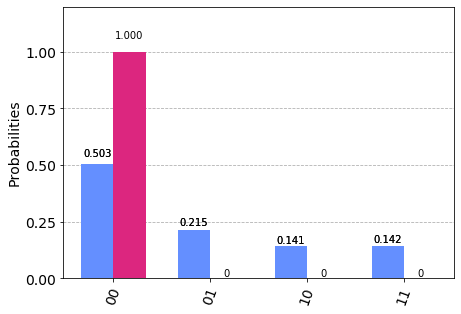

In [42]:
plot_histogram([resultCount,simul(qc)])